*Summary*
*  Load intamt data
*  Load Optical system sensitivity matrix
*  Perform standard SVD
*  Perform weighted SVD with weight 1
*  Compute sensitivity matrix using Negro84
*  Perform weighted SVD with weight from Negro84

In [1]:
#laod liraries and data
from arte.utils.zernike_projection_on_subaperture import ZernikeProjectionOnSubaperture
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

IMfile="/mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/InteractionMatrix.fits"
cmfile="/mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/CMat.fits"
hdul = fits.open(IMfile)
hdul.info()
IMat_loaded=hdul[0].data.copy()
print("scaled 1e9 loaded intmat")
with np.printoptions(precision=3, suppress=True):
    print(IMat_loaded*1e9)
hdul.close()

hdul = fits.open(cmfile)
hdul.info()
cmat=hdul[0].data.copy()
print(cmat)
hdul.close()
IMat = IMat_loaded @ np.linalg.pinv(cmat)
print("scaled 1e9 intmat projected to orthognormal commands")
with np.printoptions(precision=3, suppress=True):
    print(IMat*1e9)

Filename: /mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/InteractionMatrix.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (5, 5)   float64   
scaled 1e9 loaded intmat
[[ 1440.882   967.535  2498.833   -68.245 -5213.151]
 [ 2867.633  -226.71     90.848  5260.101   183.622]
 [-4173.39    -22.824    -1.062     1.796     2.687]
 [  -16.417  -422.737    -0.386    -8.178    -8.092]
 [   -3.616    -5.007   428.077    -5.885    -5.645]]
Filename: /mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/CMat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (5, 5)   float64   
[[   0.7    0.     0.     0.     0. ]
 [   0.   100.     0.     0.     0. ]
 [   0.     0.   100.     0.     0. ]
 [   0.  -205.     0.     3.     0. ]
 [   0.     0.  -205.     0.     3. ]]
scaled 1e9 intmat projected to orth

In [2]:
#Simulate M4 case sub-pupil
pupilRadiusInMeter = 0.7
subapsRadiusInMeter = 0.3
subapOffAxisRadiusInMeter = 0.15
subapOffAxisAzimuthInDegrees = 0
Zproj = ZernikeProjectionOnSubaperture(pupilRadiusInMeter,subapsRadiusInMeter,subapOffAxisRadiusInMeter,subapOffAxisAzimuthInDegrees)
S = Zproj.get_projection_matrix()
print("Negro84 sensitivity matrix small pupil coeffs (rows) and large pupil coeffs (columns)")
with np.printoptions(precision=3, suppress=True):
    print(S)
S_inv = np.linalg.inv(S)
print("Negro84 sensitivity matrix large pupil coeffs (rows) and small pupil coeffs (columns)")
with np.printoptions(precision=1, suppress=True):
    print(S_inv)

Negro84 sensitivity matrix small pupil coeffs (rows) and large pupil coeffs (columns)
[[ 0.429  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.429  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.318  0.     0.184  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.225  0.     0.184  0.     0.     0.     0.     0.     0.   ]
 [ 0.225 -0.     0.     0.     0.184  0.     0.     0.     0.     0.   ]
 [ 0.    -0.906  0.     0.136 -0.     0.079  0.     0.     0.     0.   ]
 [-0.739  0.     0.193  0.     0.136  0.     0.079  0.     0.     0.   ]
 [ 0.     0.083  0.     0.136  0.     0.     0.     0.079  0.     0.   ]
 [ 0.083 -0.     0.    -0.     0.136  0.     0.     0.     0.079  0.   ]
 [-0.817 -0.    -0.45   0.     0.092  0.     0.107  0.     0.     0.034]]
Negro84 sensitivity matrix large pupil coeffs (rows) and small pupil coeffs (columns)
[[   2.3   -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0. ]
 [  -0.     2.3   -0.   

In [21]:
#rec mat standard way
RMat = np.linalg.pinv(IMat)
selection = [0,1,2,5,6]
SMat = (S_inv[:,selection].T)[:,selection].T
W = SMat.T @ SMat
Uw, Dw, Vhw = np.linalg.svd(W, full_matrices=True)
#Dw[1]=1e6
W = np.diag(Dw*1e6)   #only for test purpose
print("weight matrix")
with np.printoptions(precision=1, suppress=True):
    print(W)
#new rec mat to test
RMat2 = np.linalg.inv(IMat.T @ W @ IMat) @ IMat.T @ W


weight matrix
[[1.7e+09 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.2e+09 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 1.7e+07 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 8.9e+05 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 7.5e+05]]


Text(0.5, 1.0, 'eigenvalues change ratio')

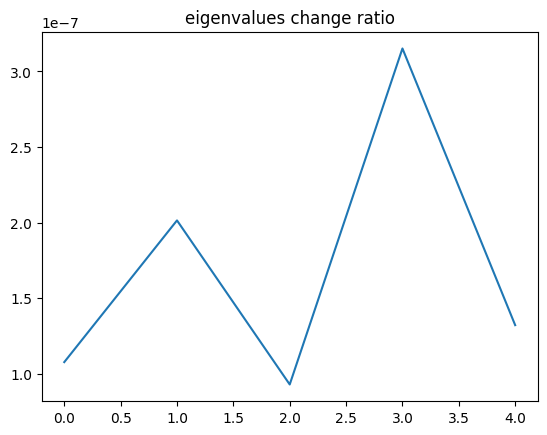

In [22]:
U, D, Vh = np.linalg.svd(RMat, full_matrices=True)
U2, D2, Vh2 = np.linalg.svd(RMat2, full_matrices=True)
Ui, Di, Vhi = np.linalg.svd(IMat, full_matrices=True)
Uw, Dw, Vhw = np.linalg.svd(W, full_matrices=True)
plt.plot(np.abs((D2-D)/D))
plt.title("eigenvalues change ratio")

Text(0.5, 1.0, 'eigenvalues change ratio')

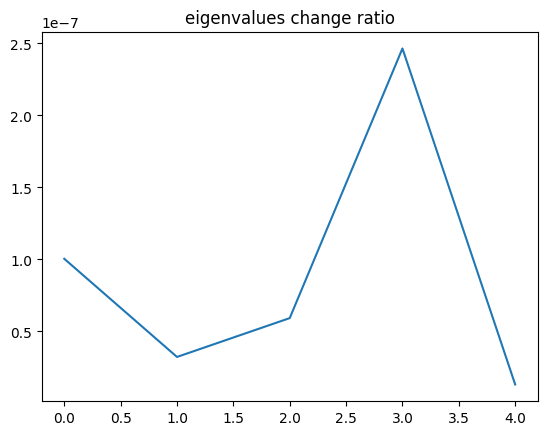

In [6]:
print(Di)
print(D)
print(D2)
print(Dw)

[7.95509985e-06 4.02887373e-06 2.92943586e-06 1.87724259e-09
 1.86123118e-09]
[5.37278770e+08 5.32696203e+08 3.41362654e+05 2.48208325e+05
 1.25705525e+05]
[5.37278780e+08 5.32696385e+08 3.41362650e+05 2.48208345e+05
 1.25705514e+05]
[1.72382944e+03 1.17774933e+03 1.69733179e+01 8.90144237e-01
 7.46038802e-01]


In [51]:
RMat

array([[-9.78116789e+01,  6.98351923e+01, -1.67749865e+05,
         8.79388802e+03,  1.47770009e+02],
       [ 3.55613649e+05, -3.64356849e+05,  8.00963598e+05,
        -2.35561692e+08, -2.20887747e+06],
       [-2.40114154e+05,  2.54401170e+05, -9.80305726e+04,
        -3.46349852e+06,  2.34947048e+08],
       [-7.08041488e+05,  1.31669730e+06, -1.24194022e+06,
         4.82625169e+08,  4.28563613e+06],
       [-8.50968422e+04, -5.27268817e+05,  6.86798142e+01,
         5.75282877e+06, -4.78271864e+08]])

In [52]:
RMat2

array([[-9.78464360e+01,  6.98429019e+01, -1.67749852e+05,
         8.79389240e+03,  1.47775415e+02],
       [ 3.55613686e+05, -3.64356865e+05,  8.00963608e+05,
        -2.35561697e+08, -2.20889512e+06],
       [-2.40114307e+05,  2.54401276e+05, -9.80305841e+04,
        -3.46349331e+06,  2.34947127e+08],
       [-7.08041528e+05,  1.31669731e+06, -1.24194025e+06,
         4.82625181e+08,  4.28567217e+06],
       [-8.50966185e+04, -5.27269033e+05,  6.87363214e+01,
         5.75281815e+06, -4.78272024e+08]])

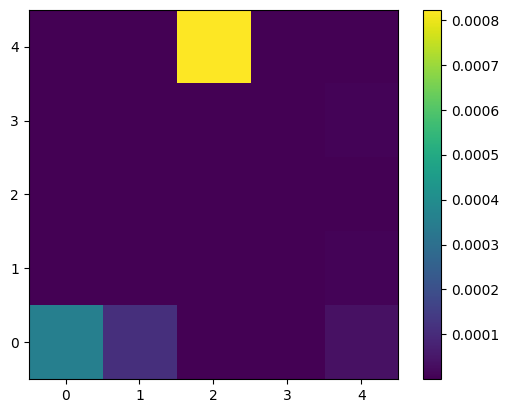

In [55]:
plt.imshow(np.abs ((RMat-RMat2)/RMat))
plt.colorbar()